<H3>PRI 2023/24: first project delivery</H3>

**GROUP 5**
- Ana Carolina Baptista, 95529
- Ådne Tøftum Svendsrud, 108703
- António Martinho do Rosário Marçal, 95735

<H3>Part I: Unsupervised Learning</H3>

A) **Sentence Clustering** 

In [36]:
import string
import os
import sys

import numpy as np

from nltk import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from transformers import BertModel, BertTokenizer
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from rank_bm25 import BM25Okapi

import matplotlib.pyplot as plt
from sklearn.metrics import auc, fbeta_score, precision_recall_curve, precision_score, roc_auc_score
from tqdm import tqdm
from os import listdir

def aux_open_file(d):
    with open(d, 'r') as doc:
        # Skip the title
        next(doc)
        
        #reading doc
        content = doc.read()
        
        # tokenization
        sentences = sent_tokenize(content)
        
        stop_words = set(stopwords.words('english'))
        punctuation = set(string.punctuation)
        punctuation.add("``")
        punctuation.add("'s")
        punctuation.add("''")
        
        preprocessed_sentences = []
        
        for sentence in sentences:
            words = word_tokenize(sentence)

            #removing stop words, pontuation, sings, lowercasing
            #some punctiation like ` and ' not being removed
            
            filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word not in punctuation]
            
            
            if filtered_words:
                preprocessed_sentences.append(" ".join(filtered_words))

        return (sentences, preprocessed_sentences)
    

def sentence_clustering(d, num_clusters=None):   
    _, preprocessed_sentences = aux_open_file(d)
        
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()       
        
    embeddings = []
        
    for sentence in preprocessed_sentences:
        input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, truncation=True, max_length=512)])

        with torch.no_grad():
            outputs = model(input_ids)
            cls_embedding = outputs[0][:, 0, :]

        embeddings.append(cls_embedding.flatten())
    
    X = np.vstack(embeddings)

    
    if num_clusters is None:
        max_clusters = len(preprocessed_sentences) // 2
        
        initial_cluster = 6
        
        last_cluster = 12
        
        if initial_cluster > max_clusters:
            initial_cluster = max_clusters
        
        if last_cluster > max_clusters:
            last_cluster = max_clusters
        
        kmeans = KMeans(n_clusters=initial_cluster, random_state=0, n_init="auto")
        
        y = kmeans.fit_predict(X)
        
        score = silhouette_score(X, y)
        melhor_n = 3
        
        for n in range(initial_cluster + 1, last_cluster):
            kmeans_atual = KMeans(n_clusters=n, random_state=0, n_init="auto")
            
            y = kmeans_atual.fit_predict(X)
        
            new_score = silhouette_score(X, y)
                
            if new_score > score:
                score = new_score
                melhor_n = n
                kmeans = kmeans_atual
        
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto")
    
        kmeans.fit(X)
    
    
    return (kmeans, embeddings)


B) **Summarization**

*B.1 Summarization solution: results for a given document*

In [40]:
def summarization(d, C):
    sentences, preprocessed_sentences = aux_open_file(d)
    
    kmeans, embeddings = C

    n_clusters = kmeans.cluster_centers_.shape[0]
    
    summarized_document = []
    
    for cluster_num in range(n_clusters):
        cluster_sentences = [doc for n, doc in enumerate(preprocessed_sentences) if kmeans.labels_[n] == cluster_num]
        original_cluster_sentences = [(n, 1) for n, doc in enumerate(sentences) if kmeans.labels_[n] == cluster_num]
                
        centroid = kmeans.cluster_centers_[cluster_num]

        # euclidian distance
        min_distance = np.linalg.norm(embeddings[0].numpy() - centroid)

        selected_sentence = 0
        
        for sentence_num in range(1, len(cluster_sentences)):
            distance = np.linalg.norm(embeddings[sentence_num].numpy() - centroid)
            
            if distance < min_distance:
                min_distance = distance
                selected_sentence = sentence_num
        
        summarized_document.append(original_cluster_sentences[selected_sentence])
    
    return summarized_document


In [42]:
d = "BBC News Summary/News Articles/sport/001.txt"
C = sentence_clustering(d)
summary = summarization(d, C)

In [ ]:
refs = vectorize_references("BBC News Summary")

summaries = []
for genre_id, genre in enumerate(("business", "entertainment", "politics", "sport", "tech")):
    for doc in tqdm(range(1, 10), desc=f"Summarising {genre} articles"):
        if doc < 10:
            filename = rf"BBC News Summary\News Articles\{genre}\00{str(doc)}.txt"
        elif doc < 100:
            filename = rf"BBC News Summary\News Articles\{genre}\0{str(doc)}.txt"
        else:
            filename = rf"BBC News Summary\News Articles\{genre}\{str(doc)}.txt"
        C = sentence_clustering(d)
        summary = summarization(d, C)
        summaries.append(((genre_id, doc - 1), summary))

with open("summaries.txt", "w") as f:
    f.write(str(summaries))
    
evaluation(summaries, refs)

C) **Keyword extraction**

In [34]:
def keyword_extraction(d,C):
    _, preprocessed_sentences = aux_open_file(d)
    
    words = set()
    
    for sentence in preprocessed_sentences:
        words = words.union(set(sentence.split()))

    words = list(words)
    
    sentence_kmeans, sentence_embeddings = C
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()       
        
    
    word_embeddings = []
    
    for word in words:
        input_ids = torch.tensor([tokenizer.encode(word, add_special_tokens=True, truncation=True, max_length=512)])

        with torch.no_grad():
            outputs = model(input_ids)
            cls_embedding = outputs[0][:, 0, :]

        word_embeddings.append(cls_embedding.flatten())
    
    
    topic_kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto")
    
    X = np.vstack(word_embeddings)
    
    y = topic_kmeans.fit_predict(X)
    
    score = silhouette_score(X, y)
    melhor_n = 4
    
    for n in range(5, 10):
        topic_kmeans_atual = KMeans(n_clusters=n, random_state=0, n_init="auto")
        
        y = topic_kmeans_atual.fit_predict(X)
        
        new_score = silhouette_score(X, y)
        
        if new_score > score:
            score = new_score
            melhor_n = n
            topic_kmeans = topic_kmeans_atual
    
    n_topics = topic_kmeans.cluster_centers_.shape[0]

    
    n_sentence_clusters = sentence_kmeans.cluster_centers_.shape[0]
    
    keywords = []
    
    
    for topic_num in range(n_topics):
        topic_words = [word for n, word in enumerate(words) if topic_kmeans.labels_[n] == topic_num]
        
        if len(topic_words) < 12:
            continue
        
        topic_embeddings = [embedding for n, embedding in enumerate(word_embeddings) if topic_kmeans.labels_[n] == topic_num]
        
        chosen_keyword = 0
        
        greatest_score = float('-inf')
        
        for word_num in range(len(topic_words)):
            score = 0.0
            
            word_embedding = topic_embeddings[word_num].numpy()
            
            for sentence_cluster_num in range(n_sentence_clusters):
                sentence_cluster_centroid = sentence_kmeans.cluster_centers_[sentence_cluster_num]
                distance = np.linalg.norm(word_embedding- sentence_cluster_centroid)
                
                distance_score = 1 / (1 + distance)
                
                score += distance_score
                
            if score > greatest_score:
                greatest_score = score
                chosen_keyword = word_num
                
            
        keywords.append(topic_words[chosen_keyword])
    
    return keywords


In [48]:
kw_numbers = []
for genre_id, genre in enumerate(("business", "entertainment", "politics", "sport", "tech")):
    for doc in tqdm(range(1, 11), desc=f"Summarising {genre} articles"):
        if doc < 10:
            filename = rf"BBC News Summary\News Articles\{genre}\00{str(doc)}.txt"
        elif doc < 100:
            filename = rf"BBC News Summary\News Articles\{genre}\0{str(doc)}.txt"
        else:
            filename = rf"BBC News Summary\News Articles\{genre}\{str(doc)}.txt"
        C = sentence_clustering(d)
        kw_numbers.append(len(keyword_extraction(filename, C)))
        

Summarising tech articles: 100%|██████████| 10/10 [01:56<00:00, 11.66s/it]


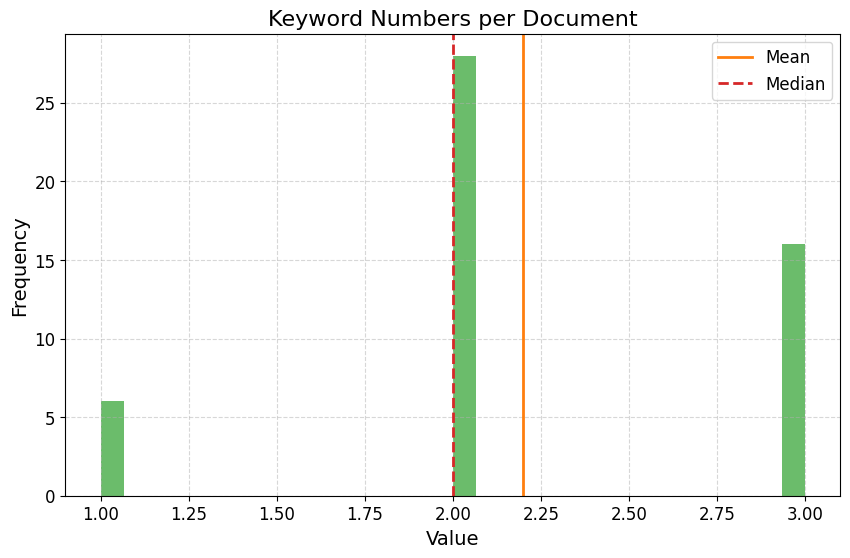

In [51]:
# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(kw_numbers, bins=30, color='#2ca02c', alpha=0.7)

# Adding a title and labels
plt.title('Keyword Numbers per Document', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding some creative styling
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(np.mean(kw_numbers), color='#ff7f0e', linestyle='-', linewidth=2, label='Mean')
plt.axvline(np.median(kw_numbers), color='#d62728', linestyle='--', linewidth=2, label='Median')
plt.legend(fontsize=12)

# Show plot
plt.show()

In [50]:
d = "BBC News Summary/News Articles/sport/001.txt"
C = sentence_clustering(d)
kw = keyword_extraction(d, C)

[3,
 2,
 1,
 3,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 3,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 2]

D) **Evaluation**

In [45]:
def vectorize_references(base_dir):
    references = []

    for genre_id, genre in enumerate(tqdm(listdir(f'{base_dir}/Summaries'), desc="Vectorizing Genres")):
        for doc_id, doc in enumerate(listdir(f"{base_dir}/Summaries/{genre}")):

            total_sentences = []
            ref_sentences = []
            with open(f"{base_dir}/News Articles/{genre}/{doc}", 'r') as f:
                total_sentences = sent_tokenize(f.read())

            with open(f"{base_dir}/Summaries/{genre}/{doc}", 'r') as f:
                ref_sentences = sent_tokenize(f.read())

            common = ()
            for i, sentence in enumerate(total_sentences):
                for ref in ref_sentences:
                    if sentence in ref:
                        common += (i,)
                        break

            references.append(((genre_id, doc_id), common))
            # print(((genre_id, doc_id), common))

    return references

def evaluation(S, Rset, beta=1.75):
    def plot_pr_curve(predictions, answers, title=""):

        plt.figure()

        # Compute precision-recall pairs for each document
        for i in range(len(answers)):
            precision, recall, t = precision_recall_curve(answers[i], predictions[i])
            plt.plot(recall, precision, marker='x', markersize=10)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        if not title:
            plt.title('Precision-Recall Curve')
        else:
            plt.title(f"Precision-Recall Curve for Genre ID = {title}")

        plt.show()

    def collapse_scores(summary_clp):
        return tuple([x[0] for x in summary_clp])

    def binarize_sets(relevant_summaries, relevant_references):

        max_sentences = 0
        for i in relevant_summaries + relevant_references:
            if max(i) > max_sentences:
                max_sentences = max(i)

        def tuple_to_binary_labels(tuple_list, max_sentences):
            binary_labels = np.zeros(max_sentences, dtype=int)
            binary_labels[np.array(tuple_list) - 1] = 1
            return binary_labels

        binary_summaries = np.array([tuple_to_binary_labels(t, max_sentences) for t in relevant_summaries])
        binary_references = np.array([tuple_to_binary_labels(t, max_sentences) for t in relevant_references])

        return binary_summaries, binary_references

    # Filtering to make sure references exist in the summaries
    sum_indexes = [summ[0] for summ in S]
    Rset = [ref for ref in Rset if ref[0] in sum_indexes]

    total_fscore = 0
    total_precision = 0
    total_auc = 0
    for genre_id in range(5):
        relevant_summaries = [collapse_scores(s[1]) for s in S if s[0][0] == genre_id]
        relevant_references = [s[1] for s in Rset if s[0][0] == genre_id]

        binary_summaries, binary_references = binarize_sets(relevant_summaries, relevant_references)

        f_score = fbeta_score(binary_references, binary_summaries, beta=beta, average="micro")
        precision = precision_score(binary_references, binary_summaries, average="micro")
        auc_score = roc_auc_score(binary_references, binary_summaries, average="micro")
        total_fscore += f_score
        total_precision += precision
        total_auc += auc_score

        print(f"Genre ID = {genre_id}")
        print(f"\tF-Measure with β = {beta} --> {f_score}")
        print(f"\tPrecision --> {precision}")
        print(f"\tAUC --> {auc_score}")

        plot_pr_curve(binary_summaries, binary_references, title=str(genre_id))

    # Pre-processing the summaries and references
    S = [collapse_scores(s[1]) for s in S]
    Rset = [s[1] for s in Rset]
    binary_S, binary_Rset = binarize_sets(S, Rset)

    print(f"Average F-Score for all the categories --> {round(total_fscore / 5, 4)}")
    print(f"The Mean Average Precision (MAP) -->  {round(total_precision / 5, 4)}")
    print(f"The Average Area Under the ROC Curve (AUC) -->  {round(total_auc / 5, 4)}")
    plot_pr_curve(binary_S, binary_Rset, "All")

<H3>Part II: Supervised Learning</H3>

A) **Feature Extraction**

In [4]:
from collections import defaultdict
from string import punctuation
from nltk.corpus import stopwords
from nltk.chunk import RegexpParser
from nltk import pos_tag, Tree

def tokenization(file):
    s = sent_tokenize(file)
    w = []
    for i in range(len(s)):
        w = w + word_tokenize(s[i])

    # each term needs a tag
    tagged_tokens = pos_tag(w)

    # define a rule for noun phrases: article + adjective + noun*
    grammar = "NP: {<DT>?<JJ>*<NN>}"
    extract = RegexpParser(grammar)
    res = extract.parse(tagged_tokens)
    
    res_list = []
    for subtree in res:
        if type(subtree) == Tree and subtree.label() == 'NP':
            res_list.append(list(subtree))

    res_final = res_list + [[token] for token in tagged_tokens]

    without_tags = [[w for (w, tag) in lista] for lista in res_final]

    return without_tags

def preprocess(word_tokens, stopwords=[]):
    
    # Lowercasing, removing stop words and ponctuation
    return_list = []
    ps = PorterStemmer()
    for term in word_tokens:
        filtered_terms = [w for w in term if w.lower() not in stopwords and w.lower() not in punctuation]
        
        #stemming
        stemmed_terms = [ps.stem(w) for w in filtered_terms]

        if len(stemmed_terms):
            return_list.append(tuple(stemmed_terms))

    return return_list

def indexing(D, stopwords_language='english'):
    index = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

    for i, genres in enumerate(tqdm(listdir(D), desc="Indexing Genres")): 
        for j, doc in enumerate(listdir(f"{D}/{genres}")):  
            # parsing
            if not doc.endswith('.txt'):
                continue

            with open(f"{D}/{genres}/{doc}", 'r') as d:
                # Skip the title
                next(d)
                # tokenization
                tokens = tokenization(d.read())

                #stop words
                stop_words = set(stopwords.words(stopwords_language))

                # removing stop words
                normalized_tokens = preprocess(tokens, stop_words)

                for token in normalized_tokens:
                                      
                    index[token][i][j] += 1

    final_index = {word: [(genre_idx, doc_idx, freq) for genre_idx, genre_docs in docs.items() for doc_idx, freq in
                          genre_docs.items()] for word, docs in index.items()}

    return final_index

In [5]:
from transformers import BertModel, BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation=True, do_lower_case=True)
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# inverted_index = indexing("BBC News Summary/News Articles")
# tfidf_vectorizer = TfidfVectorizer(vocabulary=inverted_index)
tfidf_vectorizer = TfidfVectorizer()

In [19]:
def get_bert_output(tokenizer, model, sentence, mode='cls', optype='sumsum'):
    tokenized_text = tokenizer.tokenize(sentence)
    tokens_tensor = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])
    segments_tensors = torch.tensor([[1] * len(tokenized_text)])
    outputs = model(tokens_tensor, segments_tensors)
    if mode == 'cls':
        embedding = outputs["last_hidden_state"].squeeze()[0]
    elif mode == 'pooled':
        embedding = outputs["pooler_output"].squeeze()
    else:  # 'hidden'
        layers = torch.stack(outputs['hidden_states'][-4:])
        if optype == "sumsum":
            embedding = torch.sum(layers.sum(0).squeeze(), dim=0)
        elif optype == "summean":
            embedding = torch.sum(layers.mean(0).squeeze(), dim=0)
        elif optype == "meanmean":
            embedding = torch.mean(layers.mean(0).squeeze(), dim=0)
        else:
            embedding = torch.mean(layers.sum(0).squeeze(), dim=0)
    return embedding.detach().numpy()

def feature_extraction(s_index: int, doc_name: str):
    
    with open(doc_name, 'r') as d:
        next(d)
        text = d.read()
        sentences = sent_tokenize(text)
        pragraphs = text.split('\n')

    paragraph_position = -1
    for p in pragraphs:
        for i, s in enumerate(sent_tokenize(p)):
            if s in sentences[s_index]:
                paragraph_position = i
                break
        if paragraph_position >= 0:
            break
    
    tfidf_embeddings = tfidf_vectorizer.fit_transform(sentences)
    
    tfidf_score = 0
    for j, other_sentence in enumerate(tfidf_embeddings):
        if j != s_index:
            tfidf_score += cosine_similarity(other_sentence, tfidf_embeddings[s_index])[0, 0]
    
    bm25 = BM25Okapi([s.split() for s in sentences])
    bm25_embeddings = []
    for sentence in sentences:
        bm25_embeddings.append(bm25.get_scores(sentence.split()))

    bm25_score = 0
    for j, other_sentence in enumerate(bm25_embeddings):
        if j != s_index:
            bm25_score += cosine_similarity([other_sentence], [bm25_embeddings[s_index]])[0, 0]

    bert_embeddings = []
    for sentence in sentences:
        bert_embeddings.append(get_bert_output(bert_tokenizer, bert_model, sentence, 'cls', 'sumsum'))

    bert_score = 0
    for j, other_sentence in enumerate(bert_embeddings):
        if j != s_index:
            bert_score += cosine_similarity([other_sentence], [bert_embeddings[s_index]])[0, 0]


    return (s_index, paragraph_position, tfidf_score, bm25_score, bert_score)

In [20]:
feature_extraction(8, "BBC News Summary/News Articles/sport/001.txt")

(8, 0, 1.091413748614869, 1.53377779354064, 6.3380314111709595)

B) **Training**

In [30]:
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

def training(documents, references, classifier_type = 'Naive Bayes'):

    if len(documents) != len(references):
        raise ValueError("Training documents and references must be the same size")

    # Scaling data using Min Max
    scaler = MinMaxScaler()
    documents = scaler.fit_transform(documents)

    if classifier_type == "Naive Bayes":

        classifier = MultinomialNB()
        classifier.fit(documents, references)

    elif classifier_type == "XGBoost":
        
        classifier = XGBClassifier()
        classifier.fit(documents, references)

    else:
        raise ValueError("Invalid Classifier Type. Must be Naive Bayes or XGBoost")

    return classifier

def vectorize(collection, references):

    vectors = []
    classes = []
    for i in tqdm(range(len(collection)), desc= f"Vectorizing documents"):
        with open(collection[i], 'r') as d:
            sentences = sent_tokenize(d.read())

        with open(references[i], 'r') as d:
            reference = d.read()
        
        for j in range(len(sentences)):
            try:
                vectors.append(feature_extraction(j, collection[i]))
                classes.append(int(sentences[j] in reference))
            except:
                print(f"Failure vectorizing sentence {j} of document {collection[i]}")
    
    return vectors, classes


def generate_training_samples(bus = range(510), ent = range(386), pol = range(417), spo = range(511), tec = range(401)):

    documents = []
    references = []

    root1 = "BBC News Summary/News Articles"
    root2 = "BBC News Summary/Summaries"

    files = os.listdir(f"{root1}/business")
    for i in bus:
        documents.append(f"{root1}/business/{files[i]}")
        references.append(f"{root2}/business/{files[i]}")

    files = os.listdir(f"{root1}/entertainment")
    for i in ent:
        documents.append(f"{root1}/entertainment/{files[i]}")
        references.append(f"{root2}/entertainment/{files[i]}")

    files = os.listdir(f"{root1}/politics")
    for i in pol:
        documents.append(f"{root1}/politics/{files[i]}")
        references.append(f"{root2}/politics/{files[i]}")

    files = os.listdir(f"{root1}/sport")
    for i in spo:
        documents.append(f"{root1}/sport/{files[i]}")
        references.append(f"{root2}/sport/{files[i]}")

    files = os.listdir(f"{root1}/tech")
    for i in tec:
        documents.append(f"{root1}/tech/{files[i]}")
        references.append(f"{root2}/tech/{files[i]}")

    return documents, references

In [31]:
import random
docs, refs = generate_training_samples(bus = range(100), ent = range(100), spo = range(100), pol = range(100), tec = range(100))
v_docs, class_docs = vectorize(docs, refs)

with open(f"Vectorized Dataset number {round(random.random() * 1000)}.txt", 'w') as f:
    f.write(str(v_docs) + "\n\n%%%%\n\n" + str(class_docs))

Vectorizing documents:  71%|███████▏  | 357/500 [2:01:56<1:28:23, 37.08s/it]

Failure vectorizing sentence 38 of document BBC News Summary/News Articles/sport/057.txt


Vectorizing documents: 100%|██████████| 500/500 [3:34:08<00:00, 25.70s/it]   


In [24]:
classifier = training(v_docs, class_docs, classifier_type="XGBoost")

C) **Summarization**

In [26]:
def supervised_summarization(doc, classifier, p = 1e10, l = 1e10):

    with open(doc, 'r') as d:
        sentences = sent_tokenize(d.read())

    vectors = []
    for i in range(len(sentences)):
        vectors.append(feature_extraction(i, doc))

    # Scaling data using Min Max
    scaler = MinMaxScaler()
    vectors = scaler.fit_transform(vectors)

    predictions = classifier.predict(vectors)
    summary = [(s_index, 1) for s_index in range(len(vectors)) if predictions[s_index] == 1]

    # Find out if the summary should be based on the maximum number of sentences or characters
    selected_sentences = []
    current_length = 0
    for i, (sentence_index, score) in enumerate(summary):
        sentence = sentences[sentence_index]
        current_length += len(sentence)
        # print(current_length, len(sentence), sentence_index, score)
        if current_length <= l:
            selected_sentences.append((sentence_index, score))
        else:
            break
        if len(selected_sentences) >= p:
            break

    return selected_sentences

In [27]:
supervised_summarization("BBC News Summary/News Articles/business/048.txt", classifier, l=500)

[(0, 1), (3, 1), (5, 1), (7, 1)]